In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

plt.style.use("seaborn-colorblind")

In [2]:
# Install nb_black for autoformatting
!pip install nb_black --quiet
%load_ext lab_black

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Data EDA

In [3]:
!ls ../input/asl-signs/ -GFlash --color

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
total 6.2M
   0 drwxr-xr-x  3 nobody    0 Feb 18 17:19 ./
4.0K drwxr-xr-x  3 root   4.0K May  6 00:10 ../
4.0K -rw-r--r--  1 nobody 3.3K Feb 18 17:19 sign_to_prediction_index_map.json
6.2M -rw-r--r--  1 nobody 6.2M Feb 18 17:19 train.csv
   0 drwxr-xr-x 23 nobody    0 Feb 18 17:25 train_landmark_files/


In [4]:
BASE_DIR = "../input/asl-signs/"
train = pd.read_csv(f"{BASE_DIR}/train.csv")

In [5]:
# Train.csv has the path to each parquet file, the particpant id, sequence_id and sign.
train.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


## What Signs are we trying to predict?
- 250 Unique Signs
- Ranging from 299-415 Examples of Each

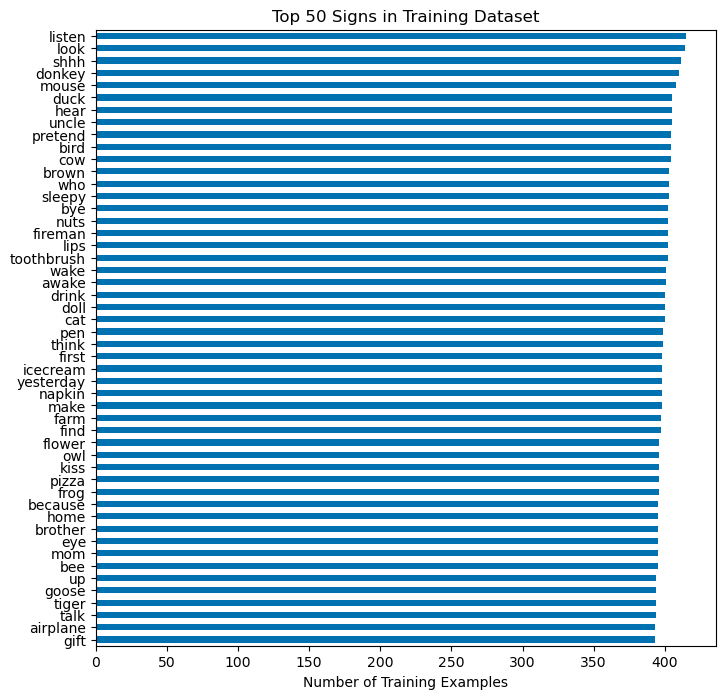

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
train["sign"].value_counts().head(50).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Top 50 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

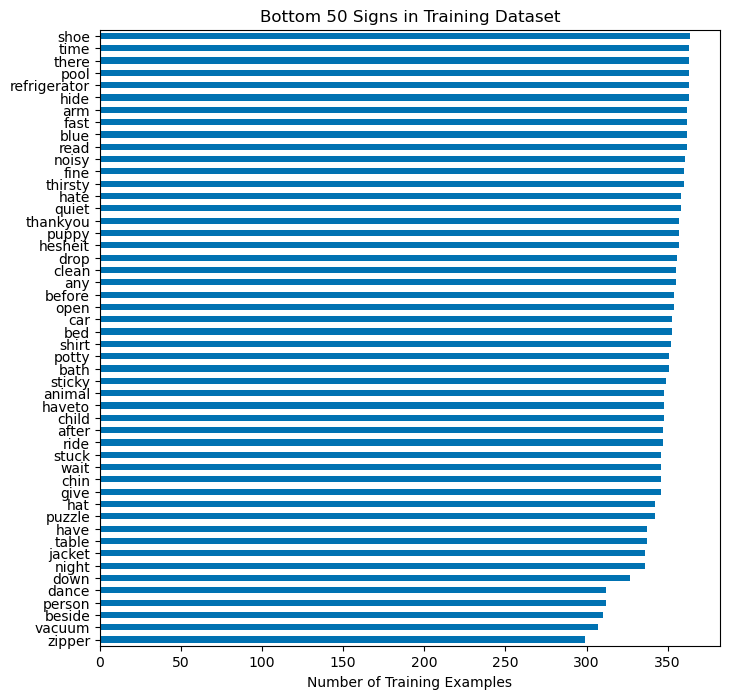

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
train["sign"].value_counts().tail(50).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Bottom 50 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

# Parquet Landmark Data
- Each Parquet file is in the path:
    - train_landmark_files/[participant_id]/[sequence_id].parquet
- The parquet's associated sign can be found in train.csv

## Pull an example parquet file data...

We pull an example landmark file for the sign "listen"

In [8]:
example_fn = train.query('sign == "listen"')["path"].values[0]

example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")
example_landmark.head()

,frame,row_id,type,landmark_index,x,y,z
0,35,35-face-0,face,0,0.556969,0.431919,-0.039614
1,35,35-face-1,face,1,0.548688,0.394788,-0.077306
2,35,35-face-2,face,2,0.548806,0.405519,-0.040327
3,35,35-face-3,face,3,0.531849,0.356302,-0.058683
4,35,35-face-4,face,4,0.547539,0.382894,-0.082544


In [9]:
unique_frames = example_landmark["frame"].nunique()
unique_types = example_landmark["type"].nunique()
types_in_video = example_landmark["type"].unique()
print(
    f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
)

The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']


## Lets Compare for a bunch of parquet files what type of data we have.
- We notice the number of frames is not consistent
- Almost every file has 4 types of landmarks: face, left_hand, pose and right_hand.

In [10]:
listen_files = train.query('sign == "listen"')["path"].values
for i, f in enumerate(listen_files):
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{f}")
    unique_frames = example_landmark["frame"].nunique()
    unique_types = example_landmark["type"].nunique()
    types_in_video = example_landmark["type"].unique()
    print(
        f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
    )
    if i == 20:
        break

The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 23 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 28 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 68 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 16 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 8 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 33 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 13 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The 

# Create Metadata for Training Dataset

In [11]:
N_PARQUETS_TO_READ = 100_000  # So we don't have to load all 95k

combined_meta = {}
for i, d in tqdm(train.iterrows(), total=len(train)):
    file_path = d["path"]
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{file_path}")
    # Get the number of landmarks with x,y,z data per type
    meta = (
        example_landmark.dropna(subset=["x", "y", "z"])["type"].value_counts().to_dict()
    )
    meta["frames"] = example_landmark["frame"].nunique()
    xyz_meta = (
        example_landmark.agg(
            {
                "x": ["min", "max", "mean"],
                "y": ["min", "max", "mean"],
                "z": ["min", "max", "mean"],
            }
        )
        .unstack()
        .to_dict()
    )

    for key in xyz_meta.keys():
        new_key = key[0] + "_" + key[1]
        meta[new_key] = xyz_meta[key]
    combined_meta[file_path] = meta
    if i >= N_PARQUETS_TO_READ:
        break

  0%|          | 0/94477 [00:00<?, ?it/s]

In [12]:
train_with_meta = train.merge(
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={"index": "path"}),
    how="left",
)
train_with_meta.to_parquet("train_with_meta.parquet")

## What are the most frequent types of landmarks provided?
- Face has a lot more datapoints because mediapipe provides 468 3D datapoints per frame.

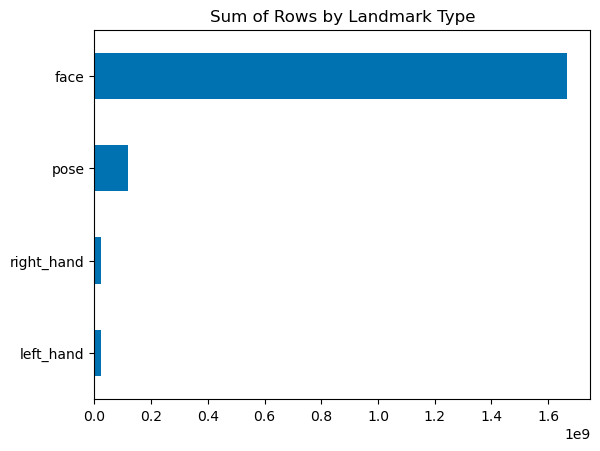

In [13]:
train_with_meta[["face", "pose", "left_hand", "right_hand"]].sum().sort_values().plot(
    kind="barh", title="Sum of Rows by Landmark Type"
)
plt.show()

Every parquet file has at least some datapoints for all four types of landmarks:
    - Face, pose, left hand and right hand.

<AxesSubplot:title={'center':'Rate of Frame/Keypoints with Data'}>

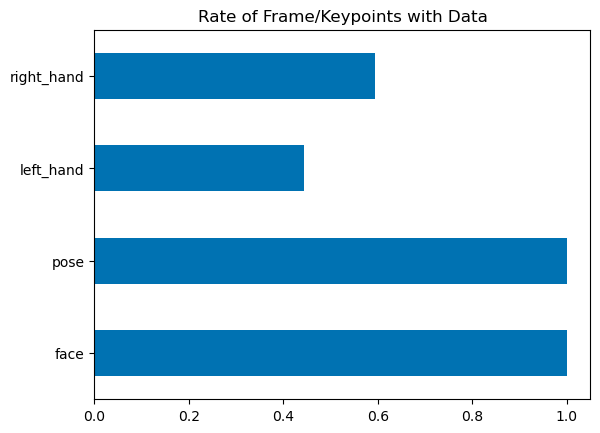

In [14]:
# checking to see if the number of landmarks for this type is zero
(
    train_with_meta.query("index < 1000").fillna(0)[
        ["face", "pose", "left_hand", "right_hand"]
    ]
    > 0
).mean().plot(kind="barh", title="Rate of Frame/Keypoints with Data")

# Check out one Example

In [15]:
example_fn = train_with_meta.dropna().query('sign == "shhh"')["path"].values[0]
example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")

In [16]:
example_landmark.query("frame == 25")["type"].value_counts()  # Middle of the video

face          468
pose           33
left_hand      21
right_hand     21
Name: type, dtype: int64

In [17]:
example_landmark["no_xyz"] = example_landmark["x"].isna()

<AxesSubplot:title={'center':'missing xyz per frame'}, xlabel='frame'>

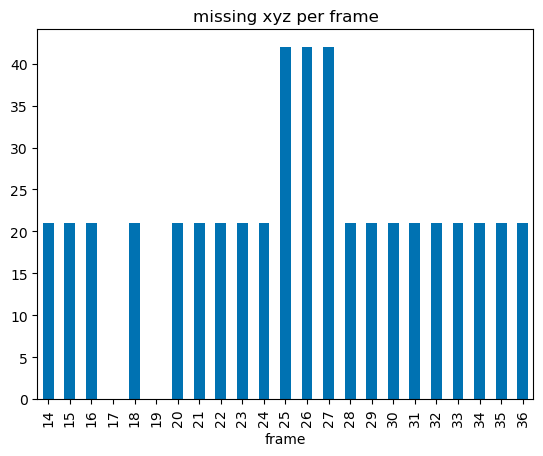

In [18]:
example_landmark.groupby("frame")["no_xyz"].sum().plot(
    title="missing xyz per frame", kind="bar"
)

## 3D plot of Landmarks from "shhh" example
Pick frame 17 because we have no missing xyz data

In [19]:
import plotly.express as px

example_frame = example_landmark.query("frame == 17")
px.scatter_3d(example_frame, x="x", y="y", z="z", color="type")

In [20]:
example_landmark["y_"] = example_landmark["y"] * -1
example_frame = example_landmark.query("frame == 17 and type== 'face'")
px.scatter(example_frame, x="x", y="y_", color="type")

# Try to draw the example with mediapipe's hand connections?

In [21]:
!pip install mediapipe --quiet

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires flatbuffers<2,>=1.12, but you have flatbuffers 23.3.3 which is incompatible.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.3 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-serving-api 2.10.0 requires tensorflow<3,>=2.10.0, but you have tensorflow 2.9.2 which is incompatible.


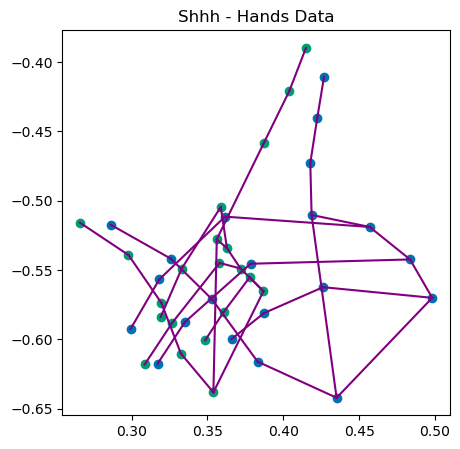

In [22]:
import mediapipe as mp

mp_hands = mp.solutions.hands


example_landmark["y_"] = example_landmark["y"] * -1

fig, ax = plt.subplots(figsize=(5, 5))

for hand in ["left_hand", "right_hand"]:
    example_hand = example_landmark.query("frame == 17 and type == @hand")

    ax.scatter(example_hand["x"], example_hand["y_"])

    for connection in mp_hands.HAND_CONNECTIONS:
        point_a = connection[0]
        point_b = connection[1]
        x1, y1 = example_hand.query("landmark_index == @point_a")[["x", "y_"]].values[0]
        x2, y2 = example_hand.query("landmark_index == @point_b")[["x", "y_"]].values[0]
        plt.plot([x1, x2], [y1, y2], color="purple")
ax.set_title("Shhh - Hands Data")
plt.show()

In [23]:
!wget https://i.ytimg.com/vi/mi9f9zOaqM8/hqdefault.jpg --quiet
!wget https://previews.123rf.com/images/mimagephotography/mimagephotography1411/mimagephotography141100022/33214722-full-length-portrait-of-a-fashionable-young-man-standing-on-isolated-white-background.jpg --quiet

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [24]:
import cv2
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic

# For static images:
IMAGE_FILES = [
    "hqdefault.jpg",
    "33214722-full-length-portrait-of-a-fashionable-young-man-standing-on-isolated-white-background.jpg",
]
BG_COLOR = (192, 192, 192)  # gray
with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    refine_face_landmarks=True,
) as holistic:
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        image_height, image_width, _ = image.shape
        # Convert the BGR image to RGB before processing.
        results = holistic.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        if results.pose_landmarks:
            print(
                f"Nose coordinates: ("
                f"{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].x * image_width}, "
                f"{results.pose_landmarks.landmark[mp_holistic.PoseLandmark.NOSE].y * image_height})"
            )

        annotated_image = image.copy()
        # Draw segmentation on the image.
        # To improve segmentation around boundaries, consider applying a joint
        # bilateral filter to "results.segmentation_mask" with "image".
        condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
        bg_image = np.zeros(image.shape, dtype=np.uint8)
        bg_image[:] = BG_COLOR
        annotated_image = np.where(condition, annotated_image, bg_image)
        # Draw pose, left and right hands, and face landmarks on the image.
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style(),
        )
        mp_drawing.draw_landmarks(
            annotated_image,
            results.pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
        )
        cv2.imwrite("/tmp/annotated_image" + str(idx) + ".png", annotated_image)
        # Plot pose world landmarks.
#         mp_drawing.plot_landmarks(
#             results.pose_world_landmarks, mp_holistic.POSE_CONNECTIONS
#         )

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Nose coordinates: (414.55575942993164, 161.42556309700012)
Nose coordinates: (433.83578807115555, 152.842178940773)


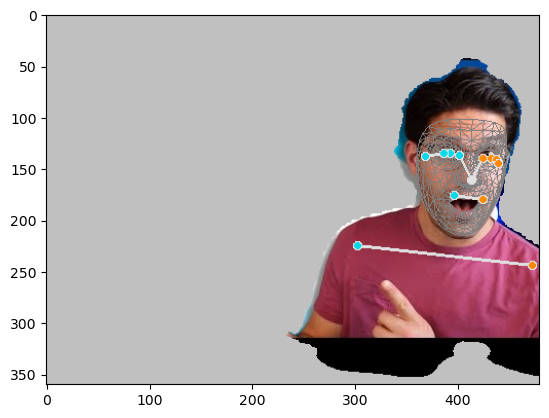

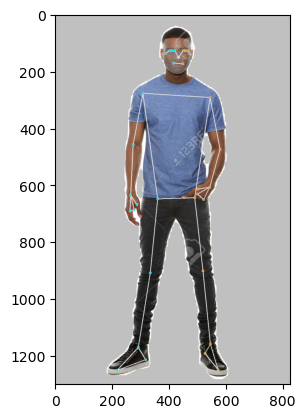

In [25]:
plt.imshow(plt.imread("/tmp/annotated_image" + str(0) + ".png"))
plt.show()

plt.imshow(plt.imread("/tmp/annotated_image" + str(1) + ".png"))
plt.show()

# Try to use the same format for plotting of parquet data

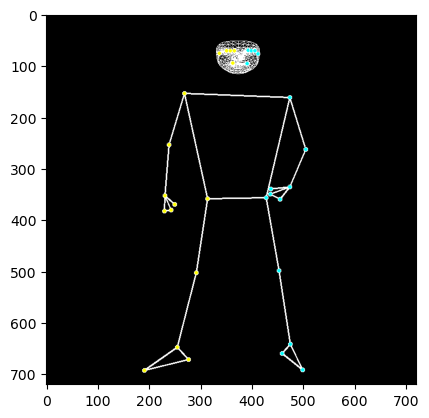

In [26]:
background_image = np.zeros([720, 720, 3])

mp_drawing.draw_landmarks(
    background_image,
    results.face_landmarks,
    mp_holistic.FACEMESH_TESSELATION,
    landmark_drawing_spec=None,
    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style(),
)
mp_drawing.draw_landmarks(
    background_image,
    results.pose_landmarks,
    mp_holistic.POSE_CONNECTIONS,
    landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
)
plt.imshow(background_image)

In [27]:
type(results.face_landmarks)

from mediapipe.framework.formats import landmark_pb2

# face_landmarks = landmark_pb2.NormalizedLandmarkList(example_frame.query('type == "face"')[["x", "y", "z"]].values)

In [28]:
def load_relevant_data_subset(pq_path):
    data_columns = ["x", "y", "z"]
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [29]:
# import tflite_runtime.interpreter as tflite

# def run_model(model_path):
#     interpreter = tflite.Interpreter(model_path)

#     found_signatures = list(interpreter.get_signature_list().keys())

#     if REQUIRED_SIGNATURE not in found_signatures:
#         raise KernelEvalException('Required input signature not found.')

#     prediction_fn = interpreter.get_signature_runner("serving_default")
#     output = prediction_fn(inputs=frames)
#     sign = np.argmax(output["outputs"])